In [1]:
import pandas as pd
import psycopg2
from datetime import timezone
import datetime
import json

In [2]:
sensorid_List = 18699,18749
timestamp_start = datetime.datetime(2021, 7, 25)
timestamp_end = datetime.datetime(2021, 7, 31)

In [3]:
print(timestamp_start)
print(timestamp_end)

timestamp_start = int(timestamp_start.replace(tzinfo=timezone.utc).timestamp())
timestamp_end = int(timestamp_end.replace(tzinfo=timezone.utc).timestamp())

print(timestamp_start)
print(timestamp_end)

2021-07-25 00:00:00
2021-07-31 00:00:00
1627171200
1627689600


In [4]:
try: 
    #Connecting to an existing database
    con = psycopg2.connect(
        host="localhost",
        database="airQuality",
        user="Riyad", 
        password="123",
        connect_timeout = 3)  # attempt to connect for 3 seconds then raise exception

except (Exception, psycopg2.Error) as error:
    print("Error while exchanging data from PostgreSQL", error)



In [5]:
#Opening a cursor to execute database operations
cursor = con.cursor()

# get the sensorid from lookup table
query = "SELECT id FROM sensor_network.sensors WHERE lookup_id IN {}".format(sensorid_List)
cursor.execute(query)
sensor_ids = cursor.fetchall()
print(sensor_ids)

cursor.close()

[(7,), (9,)]


In [6]:
#creating local lookup dictionary
lookup_dictionary = {k:v for k,v in zip(sensorid_List,sensor_ids)}
for key in lookup_dictionary:
    (sensor_id,) = lookup_dictionary[key]
    lookup_dictionary[key] = sensor_id
    print(key)
    print(lookup_dictionary[key])

18699
7
18749
9


In [7]:
sensor_dictionary = {}

for current_sensor_id in sensor_ids:

    df_List = [] 

    (sensor_id,) = current_sensor_id

    #Opening a cursor to execute database operations
    cursor = con.cursor()

    #get sensor_data_id from sensor_summary records
    query = "SELECT sensor_data_id ,timestamp_start  FROM sensor_network.sensor_summaries WHERE timestamp_start BETWEEN {} AND {} AND sensor_id IN ({})".format(timestamp_start,timestamp_end,sensor_id)
    cursor.execute(query)

    sensor_data_ids = cursor.fetchall()

    for current_id in sensor_data_ids:
        (data_id,timestamp_Key) = current_id
        
        query = "SELECT * FROM sensor_data.archive_measurements WHERE id = {}".format(data_id)

        #execute query into a dataframe
        data = pd.read_sql_query(query, con, index_col='id')
        df_List.append(data)

    #you need to concat the df here 
    sensor_dictionary[sensor_id] = pd.concat(df_List)
    cursor.close()

#clear dflist
df_List = []

In [8]:
if con:
    con.close()
    print("PostgreSQL connection is closed")

PostgreSQL connection is closed


# Converting JSON to dataframes

In [9]:
def convertToJson(count,dictionary_name):
    my_json_string = str(df.loc[df.index.values[count]][dictionary_name])
    my_json_string = my_json_string.replace("\'","\"").replace("None","null")

    # reading the JSON data using json.loads(json string)
    # converting json dataset from dictionary to dataframe 
    dict_data = json.loads(my_json_string)
    data = pd.DataFrame.from_dict(dict_data, orient='columns')
        
    #!!!! There is a better way to do this probably
    #convert string index to integer
    data.insert(0, 'timestamp', data.index.astype(int))
    data.set_index('timestamp',inplace=True)

    #make a new day column to store the datetime.date of each record
    data.insert(0, 'date', pd.to_datetime(data.index.values, unit='s', errors='coerce'))

    return data

In [10]:
measurement_dictionary = {}
location_dictionary = {}

In [11]:
for key in sensor_dictionary:
    
    #creating empty lists to store each dataframe.
    df_measurement_List = []
    df_location_List = []
    
    df = sensor_dictionary[key]

    for i in range(len(df.index.values)):
        df_measurement_List.append(convertToJson(i,'measurements'))
        df_location_List.append(convertToJson(i,'locations'))
        
    #concatentate each dataframe in the list into one. Assign this new Joined dataframe to the sensor
    location_dictionary[key] = pd.concat(df_location_List)
    measurement_dictionary[key] = pd.concat(df_measurement_List)

#clear sensor_dictionary and lists
sensor_dictionary = {}
df_measurement_List = []
df_location_List = []

# Visualing data

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
import matplotlib.dates as mdates

# 13:22 Pm1 anomaly

In [13]:
Lucy_sensor_id = 18699
sensor_id = lookup_dictionary[Lucy_sensor_id]
df_temp = measurement_dictionary[sensor_id]

In [14]:
lookup_timestamp_start = datetime.datetime(2021, 7, 25,13,00,00,00)
lookup_timestamp_end = datetime.datetime(2021, 7, 25,13,30,00,00)
lookup_timestamp_start = int(lookup_timestamp_start.replace(tzinfo=timezone.utc).timestamp())
lookup_timestamp_end = int(lookup_timestamp_end.replace(tzinfo=timezone.utc).timestamp())
print(lookup_timestamp_start)
print(lookup_timestamp_end)


#df = df_temp[(df_temp.index >= lookup_timestamp_start) & (df_temp.index <= lookup_timestamp_end)]
#13:22 is when spike happned

df = df_temp.loc[lambda x: (x.index >= lookup_timestamp_start) & (x.index <= lookup_timestamp_end)]
#df.info()

1627218000
1627219800


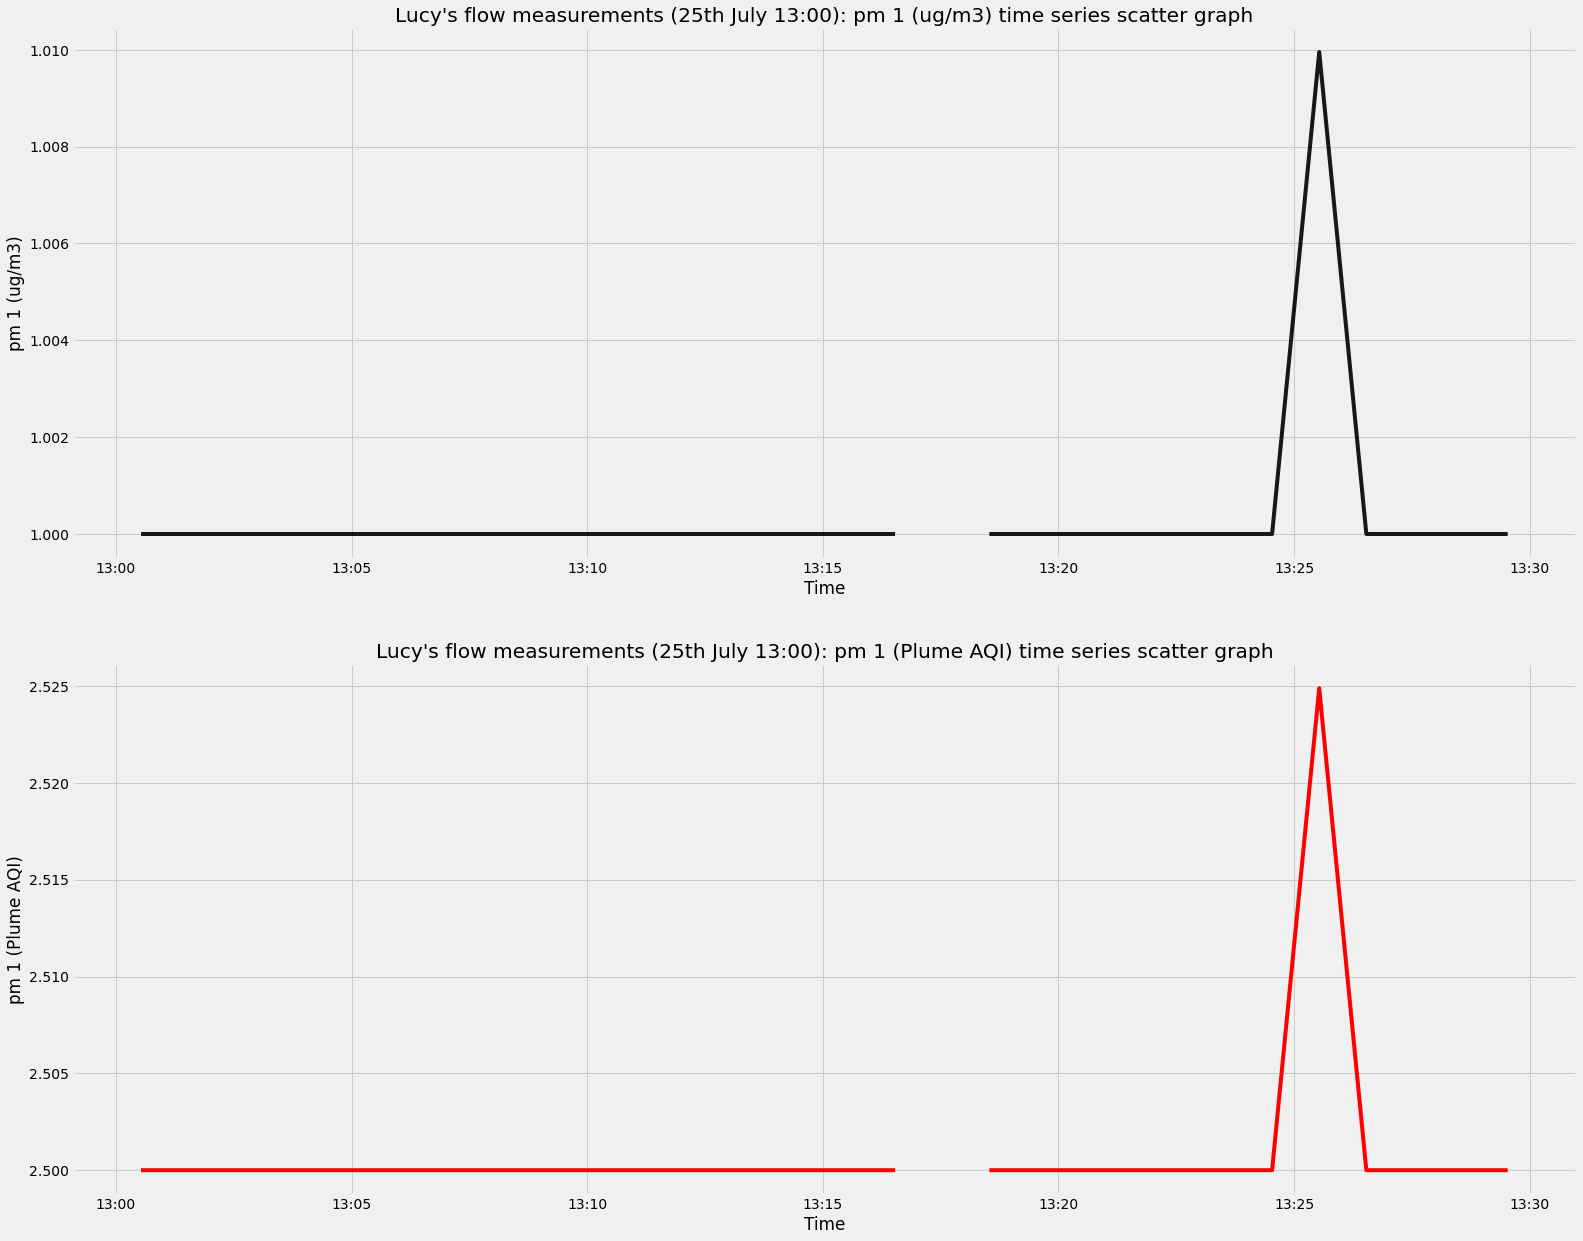

In [15]:
myTimeFormat = mdates.DateFormatter('%H:%M')

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(2, figsize = (24,20))

axs[0].set_title('Lucy\'s flow measurements (25th July 13:00): pm 1 (ug/m3) time series scatter graph')
axs[0].plot(df['date'], df["pm 1 (ug/m3)"], color = (0,0,0), linewidth = 4, alpha = .9, label = 'Raw')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("pm 1 (ug/m3)")
axs[0].xaxis.set_major_formatter(myTimeFormat)

axs[1].set_title('Lucy\'s flow measurements (25th July 13:00): pm 1 (Plume AQI) time series scatter graph')
axs[1].plot(df['date'], df["pm 1 (Plume AQI)"], color = (1,0,0), label = 'AQI')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("pm 1 (Plume AQI)")
axs[1].xaxis.set_major_formatter(myTimeFormat)

plt.show()

# 31st July 18:25, checking pm 1/2.5/10 

In [16]:
Lucy_sensor_id = 18699
sensor_id = lookup_dictionary[Lucy_sensor_id]
df_temp = measurement_dictionary[sensor_id]

In [17]:
lookup_timestamp_start = datetime.datetime(2021, 7, 31,18,00,00,00)
lookup_timestamp_end = datetime.datetime(2021, 7, 31,18,30,00,00)
lookup_timestamp_start = int(lookup_timestamp_start.replace(tzinfo=timezone.utc).timestamp())
lookup_timestamp_end = int(lookup_timestamp_end.replace(tzinfo=timezone.utc).timestamp())
print(lookup_timestamp_start)
print(lookup_timestamp_end)

df = df_temp[(df_temp.index >= lookup_timestamp_start) & (df_temp.index <= lookup_timestamp_end)]
df.info()

1627754400
1627756200
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 1627754438 to 1627756178
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                30 non-null     datetime64[ns]
 1   NO2 (ppb)           27 non-null     float64       
 2   VOC (ppb)           29 non-null     float64       
 3   pm 1 (ug/m3)        29 non-null     float64       
 4   pm 10 (ug/m3)       29 non-null     float64       
 5   pm 2.5 (ug/m3)      29 non-null     float64       
 6   NO2 (Plume AQI)     27 non-null     float64       
 7   VOC (Plume AQI)     29 non-null     float64       
 8   pm 1 (Plume AQI)    29 non-null     float64       
 9   pm 10 (Plume AQI)   29 non-null     float64       
 10  pm 2.5 (Plume AQI)  29 non-null     float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 2.8 KB


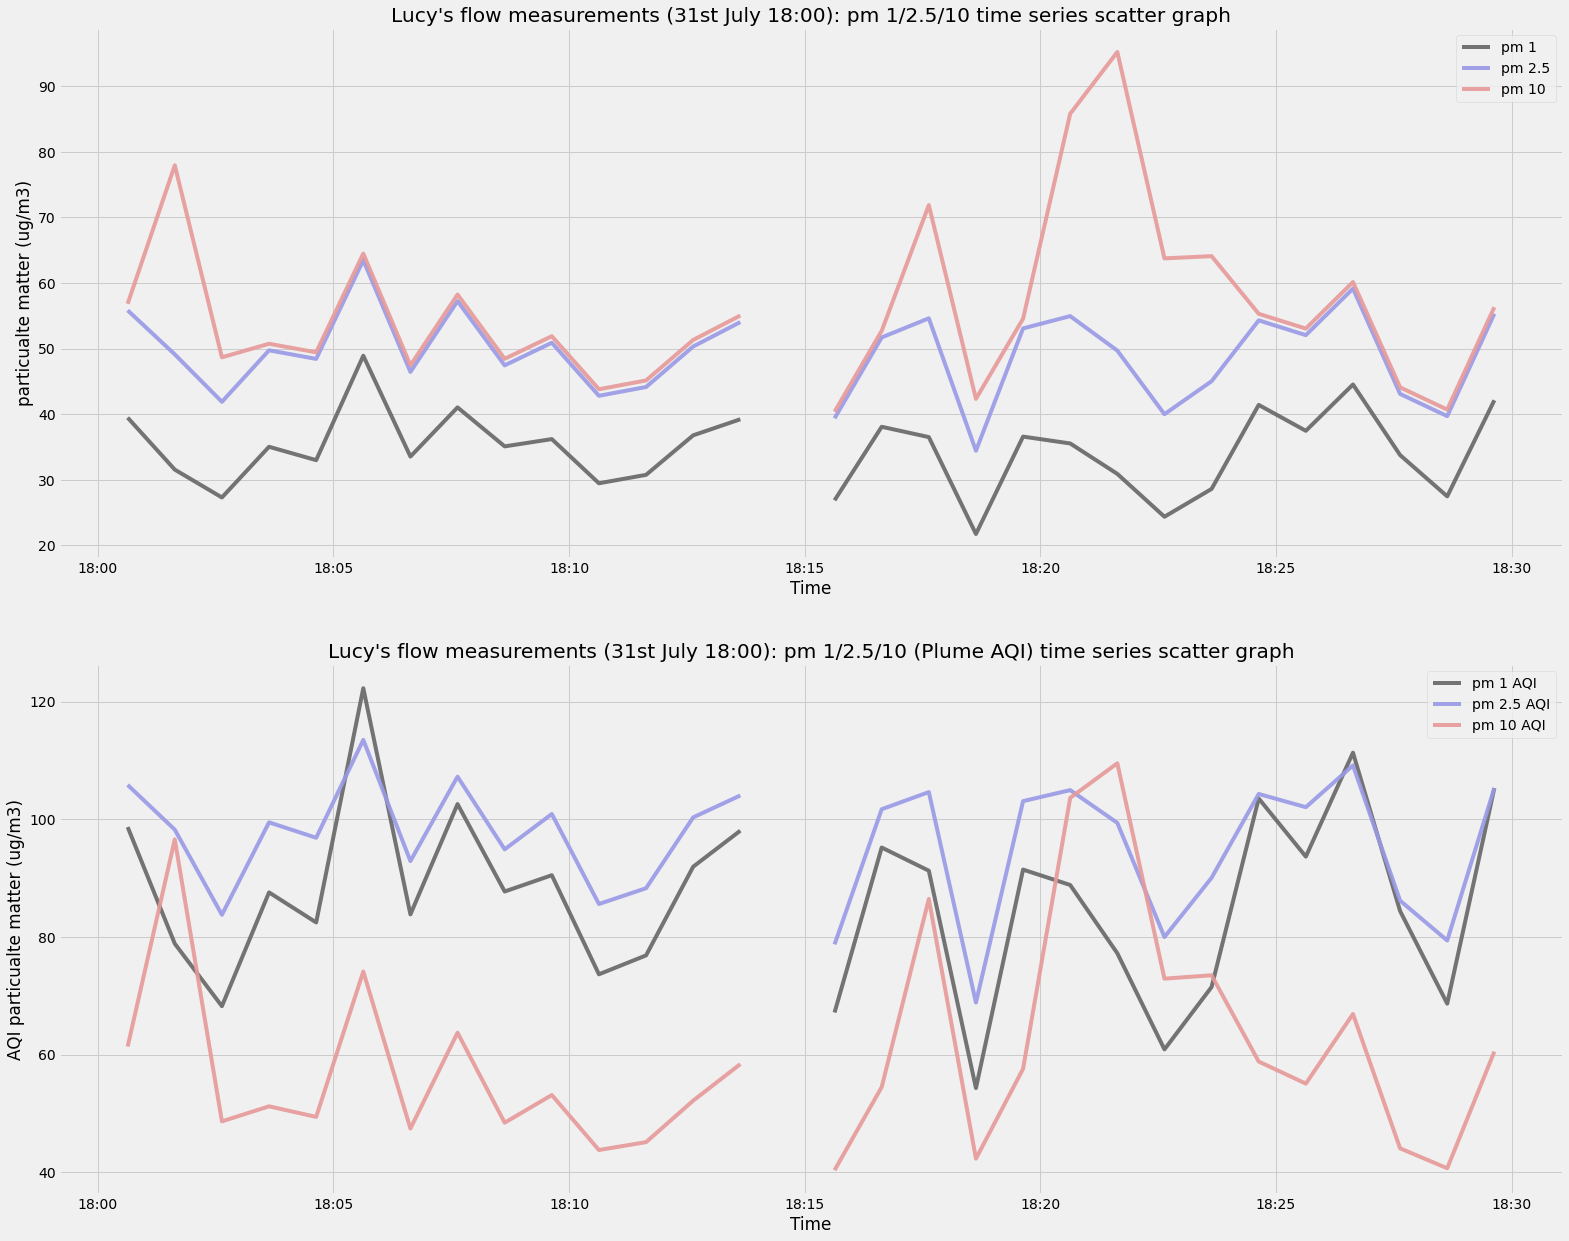

In [18]:
myTimeFormat = mdates.DateFormatter('%H:%M')

plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(2, figsize = (24,20))

axs[0].set_title('Lucy\'s flow measurements (31st July 18:00): pm 1/2.5/10 time series scatter graph')
axs[0].plot(df['date'], df["pm 1 (ug/m3)"], color = (0.4,0.4,0.4), linewidth = 4, alpha = .9, label = 'pm 1')
axs[0].plot(df['date'], df["pm 2.5 (ug/m3)"], color = (0.6,0.6,0.9), linewidth = 4, alpha = .9, label = 'pm 2.5')
axs[0].plot(df['date'], df["pm 10 (ug/m3)"], color = (0.9,0.6,0.6), linewidth = 4, alpha = .9, label = 'pm 10')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("particualte matter (ug/m3)")
axs[0].xaxis.set_major_formatter(myTimeFormat)
axs[0].legend()


axs[1].set_title('Lucy\'s flow measurements (31st July 18:00): pm 1/2.5/10 (Plume AQI) time series scatter graph')
axs[1].plot(df['date'], df["pm 1 (Plume AQI)"], color = (0.4,0.4,0.4),linewidth = 4, alpha = .9,  label = 'pm 1 AQI')
axs[1].plot(df['date'], df["pm 2.5 (Plume AQI)"], color = (0.6,0.6,0.9), linewidth = 4, alpha = .9, label = 'pm 2.5 AQI')
axs[1].plot(df['date'], df["pm 10 (Plume AQI)"], color = (0.9,0.6,0.6),  linewidth = 4, alpha = .9, label = 'pm 10 AQI')
axs[1].set_xlabel("Time")
axs[1].set_ylabel("AQI particualte matter (ug/m3)")
axs[1].xaxis.set_major_formatter(myTimeFormat)
axs[1].legend()

plt.show()